In [1]:
import numpy as np
import scipy
import crossprob
from numpy import linalg as LA
import math
from tqdm import tqdm
from dataclasses import dataclass
import torch

import matplotlib.pyplot as plt
import pandas as pd
import src.bounds as bounds
import optuna
from src.optimization import *
from datetime import datetime
import logging
from src.bounds import integrate_smooth_delta
from src.bounds import integrate_smooth_delta_upper
from src.bounds import get_upper_from_lower

In [2]:
@dataclass
class Args:
    n: int
    beta_min: float
    beta_max: float
    metric: str
    noise_init: bool = True
    noise_level: float = 0.01
    device: str = "cuda:0"
    stage_1_iter: int = 50000
    print_every: int = 100
    seed: int = 1
    save_results: bool = False
    delta: float = 0.05
    max_iter: int = 5000
    lr: float = 1e-5
    lamb: float = 5e-5
    seed_size: int = 128
    num_layers: int = 1
    hidden_dim: int = 64
    early_stop: int = 2
    g_name: str = "female_black"
    dataset: str = "civil_comments"

In [3]:
def validate(net, S, X, args):
    net.eval()
    B_0 = net(S)
    b_exp = torch.exp(B_0)
    L_final = (torch.cumsum(b_exp, 0)/(torch.sum(b_exp)+1)).detach().cpu().numpy().astype("float64")

    L_post = None
    denom = 1000000
    for j in range(denom):
        corr = j/denom
        L_corr = np.clip(L_final-corr, 0.0, 1.0)
        c = 1-args.delta-crossprob.ecdf2(L_corr, np.ones(args.n), True)

        if c < 0.0:
            L_post = L_corr
            # print(("correction:", corr, "| constraint for L_post:", c))
            break

        
    if args.metric != "delta":
        L_post_risk = quantile_based_loss(
            X, 
            torch.Tensor(L_post).cuda(), 
            beta_min=args.beta_min, 
            beta_max=args.beta_max, 
            weighted=args.weighted_loss
        )[0].item()
    else:
        L_post_risk = integrate_smooth_delta(
            np.expand_dims(X[:-1], 0), 
            L_post, 
            beta_min=args.beta_min, 
            beta_max=args.beta_max
        )[0].item()
    # print(("Optimized Bound Risk", L_post_risk))
    return L_post_risk, L_post


def run_exp(args):

    bound_save_root = "../data/civil_comments/bound_samples/{}_{}.pt".format(args.g_name, args.n)
    bound_save_root

    model_name = "g_{}_n_{}_layers_{}_seed_size_{}_hidden_{}".format(
        args.g_name,
        args.n, 
        args.num_layers, 
        args.seed_size, 
        args.hidden_dim
    )
    print(model_name)

    def phi_delta(p):
        a = 0.1
        beta = 0.5
        return (1/(a*np.pi))*np.exp(-( (p-beta)**2 / a**2 ))

    def phi(p):

        if args.metric=="mean":
            res = phi_mean(p)
        elif args.metric=="cvar":
            res = phi_cvar(args.beta_min, p)
        elif args.metric == "var_int":
            res = phi_intvar(args.beta_min, args.beta_max, p)
        elif args.metric=="p":
            res = phi_p(p)
        elif args.metric=="delta":
            res = phi_delta(p)
        else: 
            raise ValueError
        return res

    args.weighted_loss = (args.metric == "p")

    torch.manual_seed(args.seed)
    np.random.seed(args.seed)


    X_full = torch.load(bound_save_root)
    X = np.sort(X_full[:args.n], axis=-1)
    X = np.concatenate([X, [1.0]])
    X = X.astype('float128')
    X_torch = torch.Tensor(X[:-1].reshape(1,-1).astype('float64')).cuda()
    
    cons_factor = 0.25

    if args.metric == "delta":

        L_BJ = bounds.berk_jones_two_sided(args.n, args.delta, 0.0, 1.0)
        L_BJ_risk = integrate_smooth_delta(np.expand_dims(X[:-1], 0), L_BJ, beta_min=args.beta_min, beta_max=args.beta_max)[0].item()
        print(("BJ Risk", L_BJ_risk))

        L_BJ_cons = bounds.berk_jones_two_sided(args.n, cons_factor*args.delta, 0.0, 1.0)
        L_BJ_cons_risk = integrate_smooth_delta(np.expand_dims(X[:-1], 0), L_BJ_cons, beta_min=args.beta_min, beta_max=args.beta_max)[0].item()
        print(("Cons. BJ Risk", L_BJ_cons_risk))
        
        L_BJ_trunc_risk = None

    else:

        L_BJ = bounds.berk_jones_two_sided(args.n, args.delta, 0.0, 1.0)
        L_BJ_risk = quantile_based_loss(X_torch, torch.Tensor(L_BJ).cuda(), beta_min=args.beta_min, beta_max=args.beta_max, weighted=args.weighted_loss)[0].item()
        print(("BJ Risk", L_BJ_risk))
        
        L_BJ_trunc = bounds.berk_jones_two_sided(args.n, args.delta, args.beta_min, args.beta_max)
        L_BJ_trunc_risk = quantile_based_loss(X_torch, torch.Tensor(L_BJ_trunc).cuda(), beta_min=args.beta_min, beta_max=args.beta_max, weighted=args.weighted_loss)[0].item()
        print(("Trunc. BJ Risk", L_BJ_trunc_risk))

        L_BJ_cons = bounds.berk_jones_two_sided(args.n, cons_factor*args.delta, 0.0, 1.0)
        L_BJ_cons_risk = quantile_based_loss(X_torch, torch.Tensor(L_BJ_cons).cuda(), beta_min=args.beta_min, beta_max=args.beta_max, weighted=args.weighted_loss)[0].item()
        print(("Cons. BJ Risk", L_BJ_cons_risk))

    B_int = np.ones(args.n)
    B_int = B_int.astype('float128')

    S = torch.normal(0, 0.1, size=(args.n, args.seed_size)).cuda()

    net_path = "../models/seed_net/{}/{}.pt".format(args.dataset, model_name)
    print("net path", net_path)

    best_overall_score = float("INF")
    best_overall_bound = None
    best_params = None

    # for lr in [1e-4, 5e-5, 1e-5, 5e-6, 1e-6]:
    #     for lamb in [5e-4, 1e-4, 5e-5, 1e-5, 5e-6]:

    for lr in [1e-5]:
        for lamb in [5e-6]:

            print("\nNEW TRIAL")
            print("lr", lr)
            print("lamb", lamb)

            best_run_bound = None
            args.lr = lr
            args.lamb = lamb

            try:
                net = torch.load(net_path)
                optimizer = torch.optim.Adam(
                    net.parameters(),
                    args.lr,
                )

            except:

                net = SeedNet(input_dim=args.seed_size, hidden_dim=args.hidden_dim, num_layers=1)
                net.to("cuda")
                optimizer = torch.optim.Adam(
                    net.parameters(),
                    args.lr,
                )

                loss_fn = nn.MSELoss()  # mean square error
                losses = []

                n_epoch = args.stage_1_iter
                for epoch in tqdm(range(n_epoch)):

                    net.train()
                    optimizer.zero_grad()

                    B_0 = net(S)
                    b_exp = torch.exp(B_0)
                    L_0 = torch.cumsum(b_exp, 0)/(torch.sum(b_exp)+1)

                    loss = loss_fn(L_0, torch.Tensor(L_BJ_cons).to(args.device))
                    # backward pass
                    optimizer.zero_grad()
                    losses.append(loss.item())
                    loss.backward()
                    # update weights
                    optimizer.step()

                plt.plot(np.arange(n_epoch), losses)
                plt.show()
                torch.save(net, net_path)

            net.eval()
            B_0 = net(S)
            b_exp = torch.exp(B_0)
            L_0 = torch.cumsum(b_exp, 0)/(torch.sum(b_exp)+1)

            c_0 = 1-args.delta-crossprob.ecdf2(L_0.detach().cpu().numpy().astype("float64"), np.ones(args.n), True)
            print("c_0", c_0)

            best_score = 1.0

            since_best = 0

            for epoch in range(args.max_iter):

                net.train()
                optimizer.zero_grad()

                B_0 = net(S)
                b_exp = torch.exp(B_0)
                L = torch.cumsum(b_exp, 0)/(torch.sum(b_exp)+1)

                for i in range(args.n-1):
                    if L[i] > L[i+1]:
                        print(("\nNon-increasing L", L, i, L[i:]))

                grad_f = loss_grad_exp(phi, X, B_0.detach().cpu().numpy())
                grad_g = 1-args.delta-softmax_grad_exp(B_0.detach().cpu().numpy())

                if (epoch) % args.print_every == 0:

                    if args.metric != "delta":
                        loss = quantile_based_loss(X_torch, L, beta_min=args.beta_min, beta_max=args.beta_max, weighted=args.weighted_loss)[0].item()
                        score, valid_bound = validate(net, S, X_torch, args)
                    else:
                        loss = integrate_smooth_delta(np.expand_dims(X[:-1], 0), L.detach().cpu().numpy().astype("float64"), beta_min=args.beta_min, beta_max=args.beta_max)[0].item()
                        score, valid_bound = validate(net, S, X, args)
                    constraint = 1-args.delta-crossprob.ecdf2(L.detach().cpu().numpy().astype("float64"), np.ones(args.n), True)


                    print((epoch, "| loss", loss, "constraint", constraint, "Optimized Bound Risk", score))
                    if score <= best_score:
                        best_score = score
                        best_run_bound = valid_bound
                        since_best = 0
                    else:
                        since_best += 1

                b_exp.backward(torch.Tensor(grad_f+args.lamb*grad_g).cuda())
                optimizer.step()

                if since_best >= args.early_stop:
                    break

            if args.metric == "delta":
                score, L_final = validate(net, S, X, args)
            else:
                score, L_final = validate(net, S, X_torch, args)
            print((epoch, "| loss", loss, "constraint", constraint, "Optimized Bound Risk", score))

            c_final = 1-args.delta-crossprob.ecdf2(L_final, np.ones(args.n), True)
            print("final constraint", c_final)

            # best_score = min(best_score, score)

            if score <= best_score:
                best_score = score
                best_run_bound = L_final

            print(("best score:", best_score))

            if best_score < best_overall_score:
                print("New Best Run")
                best_overall_score = best_score
                best_overall_bound = best_run_bound
                best_params = {"lr": args.lr, "lamb": args.lamb}
                
    if args.metric != "delta":
        L_best_risk = quantile_based_loss(
            X_torch, 
            torch.Tensor(best_overall_bound).cuda(), 
            beta_min=args.beta_min, 
            beta_max=args.beta_max, 
            weighted=args.weighted_loss
        )[0].item()
    else:
        L_best_risk = integrate_smooth_delta(
            np.expand_dims(X[:-1], 0), 
            best_overall_bound, 
            beta_min=args.beta_min, 
            beta_max=args.beta_max
        )[0].item()
    
    X_full_sorted = torch.sort(X_full, axis=-1)[0]
    full_int = torch.arange(1, X_full.shape[0] + 1) / X_full.shape[0]

    if args.metric != "delta":
        emp_risk = quantile_based_loss(
            X_full_sorted.view(1,-1).cuda(), 
            full_int.cuda(), 
            beta_min=args.beta_min, 
            beta_max=args.beta_max, 
            weighted=args.weighted_loss
        )[0].item()
    else:
        emp_risk = integrate_smooth_delta(
            np.expand_dims(X_full, 0), 
            np.array(full_int), 
            beta_min=args.beta_min, 
            beta_max=args.beta_max
        )[0].item()
        
        
    metrics_map = {
        "cvar": "CVaR", 
        "var_int": "VaR Interval", 
        "p": "Wtd.",
        "delta": "Delta"
    }

    plt.rcParams["figure.figsize"] = (5,3)
    plt.plot(full_int, X_full_sorted, label="$F_{emp}$")
    plt.plot(torch.Tensor(best_overall_bound), X_torch.squeeze(0).cpu(), label="$G_{opt}$")
    plt.plot(torch.tensor(L_BJ), X_torch.squeeze(0).cpu(), label="$G_{BJ}$")
    if args.metric in ["cvar", "var_int"]:
        plt.plot(torch.tensor(L_BJ_trunc), X_torch.squeeze(0).cpu(), label="$G_{BJ-t}$")
        plt.xlim([0.5,1.0])
    plt.legend()
    plt.title(metrics_map[args.metric], fontsize=16)
    plt.xlabel(r'$\beta$', fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt_save_path = "../plots/opt_training/g_{}_n_{}_m_{}.png".format(args.g_name, args.n, args.metric)
    plt.savefig(plt_save_path, bbox_inches="tight")
    plt.show()

    print()
    print("Computing Target risk:", args.metric)
    print("Empirical risk:", emp_risk)
    print("G_opt:", L_best_risk, " | G_bj:", L_BJ_risk, " | G_bj-t", L_BJ_trunc_risk)
    
    results = [
        ["Empirical", args.metric, emp_risk],
        ["Opt.", args.metric, L_best_risk],
        ["BJ", args.metric, L_BJ_risk],
        ["BJ-t", args.metric, L_BJ_trunc_risk],
    ]
    
    print()
    print("Constraint values")
    c_best = 1-args.delta-crossprob.ecdf2(best_overall_bound, np.ones(args.n), True)
    c_BJ = 1-args.delta-crossprob.ecdf2(L_BJ, np.ones(args.n), True)
    if args.metric != "delta":
        c_BJ_trunc = 1-args.delta-crossprob.ecdf2(L_BJ_trunc, np.ones(args.n), True)
        print("final constraint", c_best, " | BJ constraint", c_BJ, " | BJ trunc. constraint", c_BJ_trunc)
    else: 
        print("final constraint", c_best, " | BJ constraint", c_BJ)
        
    mean_risk_best = quantile_based_loss(
        X_torch, 
        torch.Tensor(best_overall_bound).cuda(), 
        beta_min=0.0, 
        beta_max=1.0, 
        weighted=False
    )[0].item()
    mean_risk_L_bj = quantile_based_loss(
        X_torch, 
        torch.Tensor(L_BJ).cuda(), 
        beta_min=0.0, 
        beta_max=1.0, 
        weighted=False
    )[0].item()
    if args.metric != "delta":
        mean_risk_L_bj_t = quantile_based_loss(
            X_torch, 
            torch.Tensor(L_BJ_trunc).cuda(), 
            beta_min=0.0, 
            beta_max=1.0, 
            weighted=False
        )[0].item()
    else:
        mean_risk_L_bj_t = None
        
    emp_mean = quantile_based_loss(
        X_full_sorted.view(1,-1).cuda(), 
        full_int.cuda(), 
        beta_min=0.0, 
        beta_max=1.0, 
        weighted=False
    )[0].item()
        
    print()
    print("Emp. mean:", emp_mean)
    print("Mean guarantees")
    print("G_opt:", mean_risk_best, " | G_bj:", mean_risk_L_bj, " | G_bj-t:", mean_risk_L_bj_t)
    
    results.extend([
        ["Empirical", "mean", emp_mean],
        ["Opt.", "mean", mean_risk_best],
        ["BJ", "mean", mean_risk_L_bj],
        ["BJ-t", "mean", mean_risk_L_bj_t],
    ])
    
    res_df = pd.DataFrame(results, columns=["Method", "Metric", "Value"])
    return res_df

Args(n=100, beta_min=0.0, beta_max=1.0, metric='delta', noise_init=True, noise_level=0.01, device='cuda:0', stage_1_iter=50000, print_every=25, seed=2, save_results=False, delta=0.01, max_iter=10000, lr=1e-05, lamb=5e-05, seed_size=32, num_layers=3, hidden_dim=64, early_stop=2, g_name='female_black', dataset='civil_comments')

g_female_black_n_100_layers_3_seed_size_32_hidden_64
('BJ Risk', 0.00037993621576036244937)
('Cons. BJ Risk', 0.0007585758472534424183)
net path ../models/seed_net/civil_comments/g_female_black_n_100_layers_3_seed_size_32_hidden_64.pt

NEW TRIAL
lr 1e-05
lamb 5e-06
c_0 0.028571523605315452
(0, '| loss', 0.0040623934861602401316, 'constraint', 0.028571523605315452, 'Optimized Bound Risk', 0.0041119146874908963503)
(25, '| loss', 0.003987887177814243008, 'constraint', 0.02901120954524783, 'Optimized Bound Risk', 0.004038239832630519535)
(50, '| loss', 0.0039050881884569041092, 'constraint', 0.02947280926416085, 'Optimized Bound Risk', 0.003956134057712322902)
(75, 

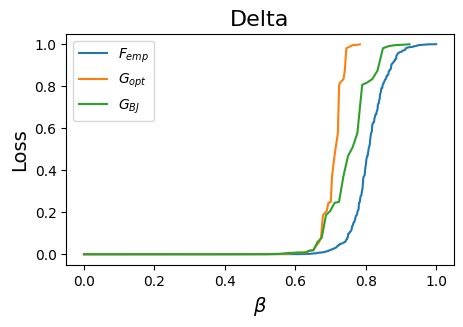


Computing Target risk: delta
Empirical risk: 1.4001012741211052e-05
G_opt: 0.00021288276649750461424  | G_bj: 0.00037993621576036244937  | G_bj-t None

Constraint values
final constraint -1.1471821514952296e-07  | BJ constraint -1.6970536087512755e-11

Emp. mean: 0.18991130590438843
Mean guarantees
G_opt: 0.2936818599700928  | G_bj: 0.2522348165512085  | G_bj-t: None


,Method,Metric,Value
0,Empirical,delta,0.000014
1,Opt.,delta,0.000213
2,BJ,delta,0.000380
3,BJ-t,delta,NaN
4,Empirical,mean,0.189911
5,Opt.,mean,0.293682
6,BJ,mean,0.252235
7,BJ-t,mean,NaN


In [4]:
args = Args(
    beta_min = 0.0,
    beta_max = 1.0,
    metric = "delta",
    n = 100,
    max_iter = 10000,
    seed = 2,
    device = "cuda:0",
    print_every = 25,
    num_layers = 3,
    seed_size = 32,
    hidden_dim = 64,
    delta = 0.01,
    g_name = "female_black"
)
print(args)
print()
delta_res_df = run_exp(args)
display(delta_res_df)

Args(n=100, beta_min=0.0, beta_max=1.0, metric='p', noise_init=True, noise_level=0.01, device='cuda:0', stage_1_iter=50000, print_every=25, seed=2, save_results=False, delta=0.01, max_iter=10000, lr=1e-05, lamb=5e-05, seed_size=32, num_layers=3, hidden_dim=64, early_stop=2, g_name='female_black', dataset='civil_comments')

g_female_black_n_100_layers_3_seed_size_32_hidden_64
('BJ Risk', 0.19151854515075684)
('Trunc. BJ Risk', 0.19151854515075684)
('Cons. BJ Risk', 0.20179708302021027)
net path ../models/seed_net/civil_comments/g_female_black_n_100_layers_3_seed_size_32_hidden_64.pt

NEW TRIAL
lr 1e-05
lamb 5e-06
c_0 0.028571523605315452
(0, '| loss', 0.2236306369304657, 'constraint', 0.028571523605315452, 'Optimized Bound Risk', 0.22376924753189087)
(25, '| loss', 0.2232772409915924, 'constraint', 0.029117013396020908, 'Optimized Bound Risk', 0.2234189808368683)
(50, '| loss', 0.22272855043411255, 'constraint', 0.029741457497520107, 'Optimized Bound Risk', 0.22287362813949585)
(75, '| 

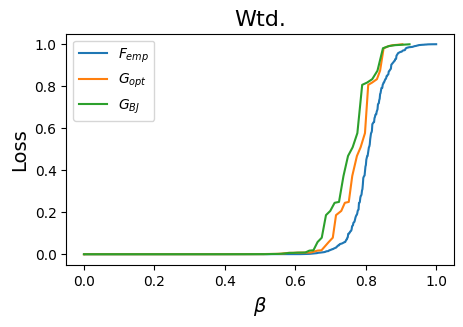


Computing Target risk: p
Empirical risk: 0.15418392419815063
G_opt: 0.17921848595142365  | G_bj: 0.19151854515075684  | G_bj-t 0.19151854515075684

Constraint values
final constraint -6.204227026573861e-07  | BJ constraint -1.6970536087512755e-11  | BJ trunc. constraint -1.6970536087512755e-11

Emp. mean: 0.18991130590438843
Mean guarantees
G_opt: 0.23021194338798523  | G_bj: 0.2522348165512085  | G_bj-t: 0.2522348165512085


,Method,Metric,Value
0,Empirical,p,0.154184
1,Opt.,p,0.179218
2,BJ,p,0.191519
3,BJ-t,p,0.191519
4,Empirical,mean,0.189911
5,Opt.,mean,0.230212
6,BJ,mean,0.252235
7,BJ-t,mean,0.252235


In [5]:
args = Args(
    beta_min = 0.0,
    beta_max = 1.0,
    metric = "p",
    n = 100,
    max_iter = 10000,
    seed = 2,
    device = "cuda:0",
    print_every = 25,
    num_layers = 3,
    seed_size = 32,
    hidden_dim = 64,
    delta = 0.01,
    g_name = "female_black"
)
print(args)
print()
wtd_res_df = run_exp(args)
display(wtd_res_df)

Args(n=100, beta_min=0.75, beta_max=1.0, metric='cvar', noise_init=True, noise_level=0.01, device='cuda:0', stage_1_iter=50000, print_every=25, seed=2, save_results=False, delta=0.01, max_iter=10000, lr=1e-05, lamb=5e-05, seed_size=32, num_layers=3, hidden_dim=64, early_stop=2, g_name='female_black', dataset='civil_comments')

g_female_black_n_100_layers_3_seed_size_32_hidden_64
('BJ Risk', 0.9116611480712891)
('Trunc. BJ Risk', 0.8637939691543579)
('Cons. BJ Risk', 0.9456421136856079)
net path ../models/seed_net/civil_comments/g_female_black_n_100_layers_3_seed_size_32_hidden_64.pt

NEW TRIAL
lr 1e-05
lamb 5e-06
c_0 0.028571523605315452
(0, '| loss', 0.9832248091697693, 'constraint', 0.028571523605315452, 'Optimized Bound Risk', 0.9834198951721191)
(25, '| loss', 0.9814481735229492, 'constraint', 0.02925391047843673, 'Optimized Bound Risk', 0.9816478490829468)
(50, '| loss', 0.9794847369194031, 'constraint', 0.02995961677481407, 'Optimized Bound Risk', 0.9796897768974304)
(75, '| loss

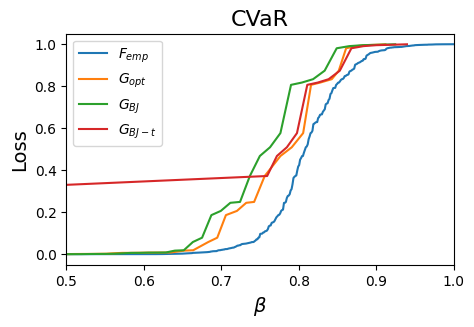


Computing Target risk: cvar
Empirical risk: 0.7483614683151245
G_opt: 0.855488121509552  | G_bj: 0.9116611480712891  | G_bj-t 0.8637939691543579

Constraint values
final constraint -4.983343921960426e-07  | BJ constraint -1.6970536087512755e-11  | BJ trunc. constraint -7.148726055561383e-13

Emp. mean: 0.18991130590438843
Mean guarantees
G_opt: 0.2304607778787613  | G_bj: 0.2522348165512085  | G_bj-t: 0.4953087568283081


,Method,Metric,Value
0,Empirical,cvar,0.748361
1,Opt.,cvar,0.855488
2,BJ,cvar,0.911661
3,BJ-t,cvar,0.863794
4,Empirical,mean,0.189911
5,Opt.,mean,0.230461
6,BJ,mean,0.252235
7,BJ-t,mean,0.495309


In [6]:
args = Args(
    beta_min = 0.75,
    beta_max = 1.0,
    metric = "cvar",
    n = 100,
    max_iter = 10000,
    seed = 2,
    device = "cuda:0",
    print_every = 25,
    num_layers = 3,
    seed_size = 32,
    hidden_dim = 64,
    delta = 0.01,
    g_name = "female_black"
)
print(args)
print()
cvar_res_df = run_exp(args)
display(cvar_res_df)

Args(n=100, beta_min=0.5, beta_max=0.9, metric='var_int', noise_init=True, noise_level=0.01, device='cuda:0', stage_1_iter=50000, print_every=25, seed=2, save_results=False, delta=0.01, max_iter=10000, lr=1e-05, lamb=5e-05, seed_size=32, num_layers=3, hidden_dim=64, early_stop=2, g_name='female_black', dataset='civil_comments')

g_female_black_n_100_layers_3_seed_size_32_hidden_64
('BJ Risk', 0.38057005405426025)
('Trunc. BJ Risk', 0.3425748348236084)
('Cons. BJ Risk', 0.42772412300109863)
net path ../models/seed_net/civil_comments/g_female_black_n_100_layers_3_seed_size_32_hidden_64.pt

NEW TRIAL
lr 1e-05
lamb 5e-06
c_0 0.028571523605315452
(0, '| loss', 0.5364949703216553, 'constraint', 0.028571523605315452, 'Optimized Bound Risk', 0.5372244715690613)
(25, '| loss', 0.5349127054214478, 'constraint', 0.029080768924769407, 'Optimized Bound Risk', 0.5356569290161133)
(50, '| loss', 0.5322408080101013, 'constraint', 0.02968202098361694, 'Optimized Bound Risk', 0.5330000519752502)
(75, '|

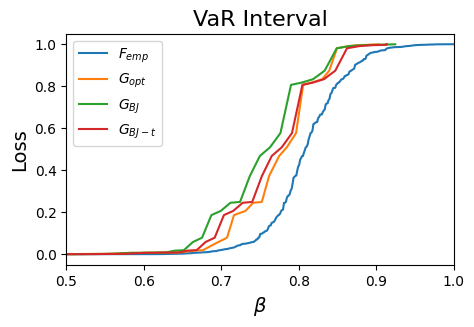


Computing Target risk: var_int
Empirical risk: 0.22700950503349304
G_opt: 0.3265611529350281  | G_bj: 0.38057005405426025  | G_bj-t 0.3425748348236084

Constraint values
final constraint -5.415714803280736e-07  | BJ constraint -1.6970536087512755e-11  | BJ trunc. constraint 1.2230327861573187e-11

Emp. mean: 0.18991130590438843
Mean guarantees
G_opt: 0.23064960539340973  | G_bj: 0.2522348165512085  | G_bj-t: 0.2371326982975006


,Method,Metric,Value
0,Empirical,var_int,0.227010
1,Opt.,var_int,0.326561
2,BJ,var_int,0.380570
3,BJ-t,var_int,0.342575
4,Empirical,mean,0.189911
5,Opt.,mean,0.230650
6,BJ,mean,0.252235
7,BJ-t,mean,0.237133


In [7]:
args = Args(
    beta_min = 0.5,
    beta_max = 0.9,
    metric = "var_int",
    n = 100,
    max_iter = 10000,
    seed = 2,
    device = "cuda:0",
    print_every = 25,
    num_layers = 3,
    seed_size = 32,
    hidden_dim = 64,
    delta = 0.01,
    g_name = "female_black"
)
print(args)
print()
var_int_res_df = run_exp(args)
display(var_int_res_df)

In [8]:
print(delta_res_df.to_latex(index=False, float_format="%.5f"))

\begin{tabular}{llr}
\toprule
   Method & Metric &   Value \\
\midrule
Empirical &  delta & 0.00001 \\
     Opt. &  delta & 0.00021 \\
       BJ &  delta & 0.00038 \\
     BJ-t &  delta &     NaN \\
Empirical &   mean & 0.18991 \\
     Opt. &   mean & 0.29368 \\
       BJ &   mean & 0.25223 \\
     BJ-t &   mean &     NaN \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1514/257500861.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(delta_res_df.to_latex(index=False, float_format="%.5f"))


In [9]:
print(wtd_res_df.to_latex(index=False, float_format="%.5f"))

\begin{tabular}{llr}
\toprule
   Method & Metric &   Value \\
\midrule
Empirical &      p & 0.15418 \\
     Opt. &      p & 0.17922 \\
       BJ &      p & 0.19152 \\
     BJ-t &      p & 0.19152 \\
Empirical &   mean & 0.18991 \\
     Opt. &   mean & 0.23021 \\
       BJ &   mean & 0.25223 \\
     BJ-t &   mean & 0.25223 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1514/1722080463.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(wtd_res_df.to_latex(index=False, float_format="%.5f"))


In [10]:
print(cvar_res_df.to_latex(index=False, float_format="%.5f"))

\begin{tabular}{llr}
\toprule
   Method & Metric &   Value \\
\midrule
Empirical &   cvar & 0.74836 \\
     Opt. &   cvar & 0.85549 \\
       BJ &   cvar & 0.91166 \\
     BJ-t &   cvar & 0.86379 \\
Empirical &   mean & 0.18991 \\
     Opt. &   mean & 0.23046 \\
       BJ &   mean & 0.25223 \\
     BJ-t &   mean & 0.49531 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1514/4193137308.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cvar_res_df.to_latex(index=False, float_format="%.5f"))


In [11]:
print(var_int_res_df.to_latex(index=False, float_format="%.5f"))

\begin{tabular}{llr}
\toprule
   Method &  Metric &   Value \\
\midrule
Empirical & var\_int & 0.22701 \\
     Opt. & var\_int & 0.32656 \\
       BJ & var\_int & 0.38057 \\
     BJ-t & var\_int & 0.34257 \\
Empirical &    mean & 0.18991 \\
     Opt. &    mean & 0.23065 \\
       BJ &    mean & 0.25223 \\
     BJ-t &    mean & 0.23713 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1514/3043503477.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(var_int_res_df.to_latex(index=False, float_format="%.5f"))


In [12]:
methods = set(cvar_res_df["Method"].tolist())

final_rows = []
for m in methods:
    final_rows.append([
        m,
        cvar_res_df[(cvar_res_df["Method"] == m) & (cvar_res_df["Metric"] == "cvar")]["Value"].item(),
        var_int_res_df[(var_int_res_df["Method"] == m) & (var_int_res_df["Metric"] == "var_int")]["Value"].item(),
        wtd_res_df[(wtd_res_df["Method"] == m) & (wtd_res_df["Metric"] == "p")]["Value"].item(),
        delta_res_df[(delta_res_df["Method"] == m) & (delta_res_df["Metric"] == "delta")]["Value"].item(),
    ])
final_res_df = pd.DataFrame(final_rows, columns=["Method", "CVaR", "VaR Interval", "Wtd.", "Delta"])

In [13]:
print(final_res_df.to_latex(index=False, float_format="%.5f"))

\begin{tabular}{lrrrr}
\toprule
   Method &    CVaR &  VaR Interval &    Wtd. &   Delta \\
\midrule
     BJ-t & 0.86379 &       0.34257 & 0.19152 &     NaN \\
     Opt. & 0.85549 &       0.32656 & 0.17922 & 0.00021 \\
Empirical & 0.74836 &       0.22701 & 0.15418 & 0.00001 \\
       BJ & 0.91166 &       0.38057 & 0.19152 & 0.00038 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1514/1318321199.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(final_res_df.to_latex(index=False, float_format="%.5f"))
